In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already u

In [2]:
# keys and tokens from the Twitter Dev Console
api_key = 'BBgvRgKen0ExqIsQJMWtJIePs'
api_key_secret = 'KHydpcdrteFvYrGyZJNtEG84Y8e8vNmu2VrUvEYmJJbMdpfHUy'
access_token = '1584502421774270465-KcpRzyzT2J33JRZb9TKLWYUnhHgbdh'
access_token_secret = '8iisp7irO73OHTdaTsC0iNZNDD64DYfSt2lFtlW0Xtzzt'

In [3]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(api_key, api_key_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search_tweets(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search_tweets(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search_tweets(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search_tweets(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [4]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('omicron', maxTweets=2000)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 89 tweets
Downloaded 174 tweets
Downloaded 252 tweets
Downloaded 345 tweets
Downloaded 437 tweets
Downloaded 537 tweets
Downloaded 627 tweets
Downloaded 727 tweets
Downloaded 816 tweets
Downloaded 896 tweets
Downloaded 988 tweets
Downloaded 1072 tweets
Downloaded 1158 tweets
Downloaded 1241 tweets
Downloaded 1330 tweets
Downloaded 1415 tweets
Downloaded 1497 tweets
Downloaded 1591 tweets
Downloaded 1671 tweets
Downloaded 1761 tweets
Downloaded 1847 tweets
Downloaded 1935 tweets
Downloaded 2012 tweets
tweets_df Shape - (1055, 1)


,tweets
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna..."
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...
3,"@PhilM64 I'm not that surprised tbh, but I thi..."
4,RT @guitarnboots: Studies indicate that new Om...
5,"RT @rickberke: via @HelenBranswell: Pfizer, Bi..."
6,Pfizer says omicron booster generates stronger...
7,RT @ChanceGardiner: Dr. Geert Vanden Bossche: ...
8,@CBCNS -3% chance of hospitalization from Omic...
9,RT @SukunaBikona7: 接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価...


### Sentiment Analysis

In [5]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [6]:
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,869
neg,186


In [7]:
tweets_df['sentiment'] = sentiments_using_SIA
tweets_df.head()

,tweets,sentiment
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg
4,RT @guitarnboots: Studies indicate that new Om...,neg


## Text Pre-processing

In [8]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [9]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos,Nieuwe varianten!\n\n#SASCoV2 Omicron BQ.1 en...
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos,"🇹🇼Le 19 mai, #Taïwan atteignait 70% de boosté..."
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos,"Spt yg dijangkakan dlm unjuran kes harian, pe..."
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg,"@PhilM64 I'm not that surprised tbh, but I thi..."
4,RT @guitarnboots: Studies indicate that new Om...,neg,Studies indicate that new Omicron subvariants...
5,"RT @rickberke: via @HelenBranswell: Pfizer, Bi...",pos,"via Pfizer, BioNTech report new Covid booster..."
6,Pfizer says omicron booster generates stronger...,pos,Pfizer says omicron booster generates stronger...
7,RT @ChanceGardiner: Dr. Geert Vanden Bossche: ...,pos,Dr. Geert Vanden Bossche: Il mio ultimo e dis...
8,@CBCNS -3% chance of hospitalization from Omic...,pos,@CBCNS -3% chance of hospitalization from Omic...
9,RT @SukunaBikona7: 接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価...,pos,接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価ワクチン接種した18-55歳で9.5...


In [10]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos,Nieuwe varianten! #SASCoV2 Omicron BQ.1 en XBB...
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos,"🇹🇼Le 19 mai, #Taïwan atteignait 70% de boostés..."
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos,"Spt yg dijangkakan dlm unjuran kes harian, pen..."
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg,"@PhilM64 I'm not that surprised tbh, but I thi..."
4,RT @guitarnboots: Studies indicate that new Om...,neg,Studies indicate that new Omicron subvariants ...
5,"RT @rickberke: via @HelenBranswell: Pfizer, Bi...",pos,"via Pfizer, BioNTech report new Covid booster ..."
6,Pfizer says omicron booster generates stronger...,pos,Pfizer says omicron booster generates stronger...
7,RT @ChanceGardiner: Dr. Geert Vanden Bossche: ...,pos,Dr. Geert Vanden Bossche: Il mio ultimo e disp...
8,@CBCNS -3% chance of hospitalization from Omic...,pos,@CBCNS -3% chance of hospitalization from Omic...
9,RT @SukunaBikona7: 接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価...,pos,接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価ワクチン接種した18-55歳で9.5倍...


In [11]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos,Nieuwe varianten! #SASCoV2 Omicron BQ.1 en XBB...
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos,"🇹🇼Le 19 mai, #Taïwan atteignait 70% de boostés..."
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos,"Spt yg dijangkakan dlm unjuran kes harian, pen..."
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg,"@PhilM64 I'm not that surprised tbh, but I thi..."
4,RT @guitarnboots: Studies indicate that new Om...,neg,Studies indicate that new Omicron subvariants ...


In [12]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos,Nieuwe varianten! #SASCoV2 Omicron BQ.1 en XBB...
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos,"🇹🇼Le 19 mai, #Taïwan atteignait 70% de boostés..."
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos,"Spt yg dijangkakan dlm unjuran kes harian, pen..."
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg,"@PhilM64 I'm not that surprised tbh, but I thi..."
4,RT @guitarnboots: Studies indicate that new Om...,neg,Studies indicate that new Omicron subvariants ...


In [13]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos,Nieuwe varianten! #SASCoV2 Omicron BQ.1 en XBB...
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos,"🇹🇼Le 19 mai, #Taïwan atteignait 70% de boostés..."
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos,"Spt yg dijangkakan dlm unjuran kes harian, pen..."
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg,"@PhilM64 I'm not that surprised tbh, but I thi..."
4,RT @guitarnboots: Studies indicate that new Om...,neg,Studies indicate that new Omicron subvariants ...


In [14]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

C:\Users\Dell\AppData\Local\Temp/ipykernel_2752/2469623561.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


In [15]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos,Nieuwe varianten! #SASCoV2 Omicron BQ.1 en XBB...,Nieuwe varianten Omicron BQ en XBB blijven het...
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos,"🇹🇼Le 19 mai, #Taïwan atteignait 70% de boostés...",Le mai atteignait de boosts Depuis le nombre d...
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos,"Spt yg dijangkakan dlm unjuran kes harian, pen...",Spt yg dijangkakan dlm unjuran kes harian peni...
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg,"@PhilM64 I'm not that surprised tbh, but I thi...",PhilM Im surprised tbh I think got way data co...
4,RT @guitarnboots: Studies indicate that new Om...,neg,Studies indicate that new Omicron subvariants ...,Studies indicate new Omicron subvariants could...
5,"RT @rickberke: via @HelenBranswell: Pfizer, Bi...",pos,"via Pfizer, BioNTech report new Covid booster ...",via Pfizer BioNTech report new Covid booster p...
6,Pfizer says omicron booster generates stronger...,pos,Pfizer says omicron booster generates stronger...,Pfizer says omicron booster generates stronger...
7,RT @ChanceGardiner: Dr. Geert Vanden Bossche: ...,pos,Dr. Geert Vanden Bossche: Il mio ultimo e disp...,Dr Geert Vanden Bossche Il mio ultimo e disper...
8,@CBCNS -3% chance of hospitalization from Omic...,pos,@CBCNS -3% chance of hospitalization from Omic...,CBCNS chance hospitalization Omicron days aver...
9,RT @SukunaBikona7: 接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価...,pos,接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価ワクチン接種した18-55歳で9.5倍...,BA


In [16]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Nieuwe, varianten, Omicron, BQ, en, XBB, blij...
1    [Le, mai, atteignait, de, boosts, Depuis, le, ...
2    [Spt, yg, dijangkakan, dlm, unjuran, kes, hari...
3    [PhilM, Im, surprised, tbh, I, think, got, way...
4    [Studies, indicate, new, Omicron, subvariants,...
Name: absolute_tidy_tweets, dtype: object

In [17]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [Nieuwe, varianten, Omicron, BQ, en, XBB, blij...
1    [Le, mai, atteignait, de, boost, Depuis, le, n...
2    [Spt, yg, dijangkakan, dlm, unjuran, kes, hari...
3    [PhilM, Im, surprised, tbh, I, think, got, way...
4    [Studies, indicate, new, Omicron, subvariants,...
Name: absolute_tidy_tweets, dtype: object

In [18]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos,Nieuwe varianten! #SASCoV2 Omicron BQ.1 en XBB...,Nieuwe varianten Omicron BQ en XBB blijven het...
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos,"🇹🇼Le 19 mai, #Taïwan atteignait 70% de boostés...",Le mai atteignait de boost Depuis le nombre de...
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos,"Spt yg dijangkakan dlm unjuran kes harian, pen...",Spt yg dijangkakan dlm unjuran kes harian peni...
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg,"@PhilM64 I'm not that surprised tbh, but I thi...",PhilM Im surprised tbh I think got way data co...
4,RT @guitarnboots: Studies indicate that new Om...,neg,Studies indicate that new Omicron subvariants ...,Studies indicate new Omicron subvariants could...
5,"RT @rickberke: via @HelenBranswell: Pfizer, Bi...",pos,"via Pfizer, BioNTech report new Covid booster ...",via Pfizer BioNTech report new Covid booster p...
6,Pfizer says omicron booster generates stronger...,pos,Pfizer says omicron booster generates stronger...,Pfizer say omicron booster generates stronger ...
7,RT @ChanceGardiner: Dr. Geert Vanden Bossche: ...,pos,Dr. Geert Vanden Bossche: Il mio ultimo e disp...,Dr Geert Vanden Bossche Il mio ultimo e disper...
8,@CBCNS -3% chance of hospitalization from Omic...,pos,@CBCNS -3% chance of hospitalization from Omic...,CBCNS chance hospitalization Omicron day avera...
9,RT @SukunaBikona7: 接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価...,pos,接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価ワクチン接種した18-55歳で9.5倍...,BA


# Pre-processing 'Key Phrases' 

In [19]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

In [20]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [21]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['nieuwe', 'ascov2 omicron', ' xbb', 'het nieuws', 'dominante versies'],
 ['mai', 'boostés', 'depuis', 'covid', 'plus que', 'pour passer'],
 ['spt',
  'dlm unjuran kes',
  'peningkatan kes covid-19 bulan nov amp',
  'dec',
  'adalah disebabkan oleh varian'],
 ['philm64', 'tbh', " it'", 'way', 'data'],
 ['study', 'new omicron subvariants', ' cov id-19 surge'],
 ['pfizer',
  'biontech',
  'new covid booster',
  'recent omicron variant',
  'origi'],
 ['pfizer',
  'omicron booster generates',
  'protection',
  'original shot',
  'expert',
  'data',
  'nbcnews'],
 ['geert vanden bossche',
  'disperato',
  'azione',
  'quanto omicron',
  'provoca una fuga immunitari'],
 ['@cbc',
  'chance',
  'hospitalization',
  'omicron',
  'day average hospitalization duration',
  'unvaccinated wor'],
 ['接種1ヶ月後こba', '従来型接種者では2', '従来型接種者と比べ2価ワクチン接']]

In obtained key phrases, we can see words like 'vaccine', 'booster', 'increased reinfection', 'omicron' etc. are present which should never be considered as key phrases. There is one other simple way to extract key phrases.

In [22]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['nieuwe varianten',
  'omicron bq.1',
  'xbb blijven',
  'zijn de meest dominante versies van sas-cov-2 op…'],
 ['🇹🇼le 19', 'depuis', "' covid"],
 ['spt yg dijangkakan dlm unjuran kes harian',
  'peningkatan kes covid-19 pd bulan nov',
  'dec 2022 adalah disebabkan oleh varian om…'],
 [],
 ['new omicron subvariants', 'cause devastating covid-19 surge'],
 ['pfizer', 'biontech report new covid booster', 'recent omicron variants'],
 ['pfizer', 'omicron booster', 'original shot'],
 ['dr. geert vanden bossche',
  'il mio ultimo e disperato invito',
  'quanto omicron ora provoca una fuga immunitari…'],
 ['omicron', '5.5 days average hospitalization duration'],
 ['接種1ヶ月後こba.4/5に対する幾何平均抗体価は2価ワクチン接種した18-55歳で9.5倍上昇し606、56歳以上で13.2倍上昇し896。一方、従来型接種者では2.9倍上昇し236。 56歳以上において、従来型接種者と比べ2価ワクチン接…']]

These key phrases have important terms and keywords. We can use this further.

In [23]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,RT @Marc_Veld: Nieuwe varianten!\n\n#SARSCoV2 ...,pos,Nieuwe varianten! #SASCoV2 Omicron BQ.1 en XBB...,Nieuwe varianten Omicron BQ en XBB blijven het...,"[nieuwe varianten, omicron bq.1, xbb blijven, ..."
1,"RT @felicittina: 🇹🇼Le 19 mai, #Taïwan atteigna...",pos,"🇹🇼Le 19 mai, #Taïwan atteignait 70% de boostés...",Le mai atteignait de boost Depuis le nombre de...,"[🇹🇼le 19, depuis, ' covid]"
2,RT @DGHisham: Spt yg dijangkakan dlm unjuran k...,pos,"Spt yg dijangkakan dlm unjuran kes harian, pen...",Spt yg dijangkakan dlm unjuran kes harian peni...,"[spt yg dijangkakan dlm unjuran kes harian, pe..."
3,"@PhilM64 I'm not that surprised tbh, but I thi...",neg,"@PhilM64 I'm not that surprised tbh, but I thi...",PhilM Im surprised tbh I think got way data co...,[]
4,RT @guitarnboots: Studies indicate that new Om...,neg,Studies indicate that new Omicron subvariants ...,Studies indicate new Omicron subvariants could...,"[new omicron subvariants, cause devastating co..."
5,"RT @rickberke: via @HelenBranswell: Pfizer, Bi...",pos,"via Pfizer, BioNTech report new Covid booster ...",via Pfizer BioNTech report new Covid booster p...,"[pfizer, biontech report new covid booster, re..."
6,Pfizer says omicron booster generates stronger...,pos,Pfizer says omicron booster generates stronger...,Pfizer say omicron booster generates stronger ...,"[pfizer, omicron booster, original shot]"
7,RT @ChanceGardiner: Dr. Geert Vanden Bossche: ...,pos,Dr. Geert Vanden Bossche: Il mio ultimo e disp...,Dr Geert Vanden Bossche Il mio ultimo e disper...,"[dr. geert vanden bossche, il mio ultimo e dis..."
8,@CBCNS -3% chance of hospitalization from Omic...,pos,@CBCNS -3% chance of hospitalization from Omic...,CBCNS chance hospitalization Omicron day avera...,"[omicron, 5.5 days average hospitalization dur..."
9,RT @SukunaBikona7: 接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価...,pos,接種1ヶ月後こBA.4/5に対する幾何平均抗体価は2価ワクチン接種した18-55歳で9.5倍...,BA,[接種1ヶ月後こba.4/5に対する幾何平均抗体価は2価ワクチン接種した18-55歳で9.5...


In [24]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

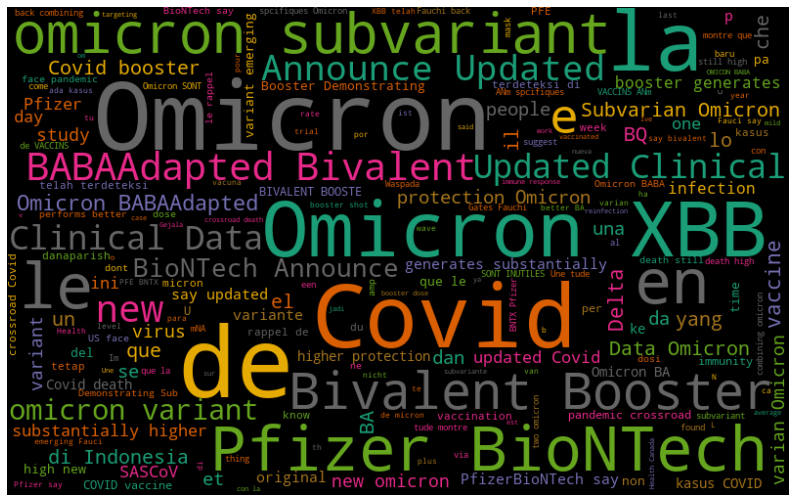

In [25]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

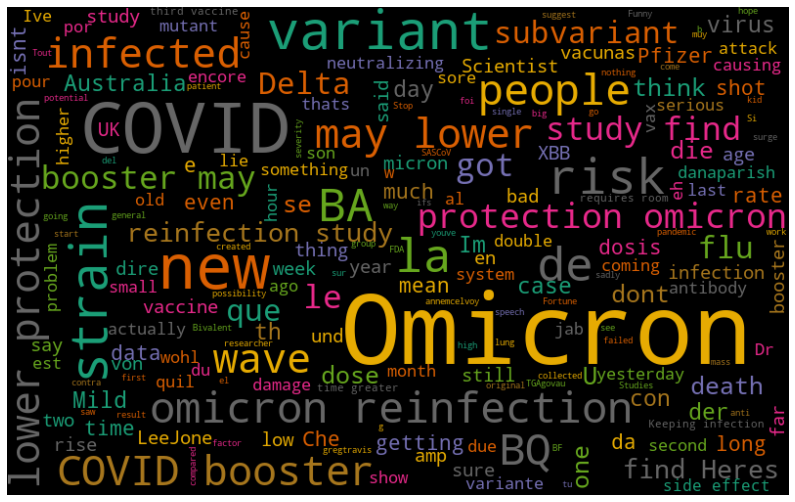

In [26]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'neg']])
generate_wordcloud(all_words)

- One thing to notice here is that word _'Omicron'_ has been used more than _'COVID', in both positive word cloud and negative word cloud.
- The word 'variant' and 'infection' dominates in the negative word cloud. Similarly, the word 'booster' and 'health' dominates in the positive word cloud.

In [27]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [28]:
hashtags = hashtag_extract(tweets_df['tidy_tweets'])
hashtags = sum(hashtags, [])

C:\Users\Dell\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 22909 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Dell\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 29992 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Dell\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Dell\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 32763 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Dell\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 22681 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Dell\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 36719 missing from current

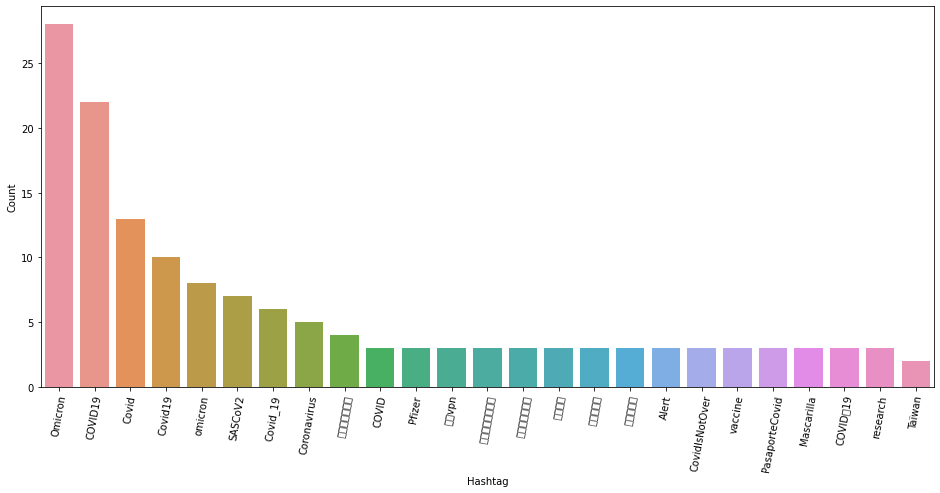

In [29]:
generate_hashtag_freqdist(hashtags)

As expected, omicron is the most common hashtag. The hashtags 'middaynews' and 'teoriaomicron' are the most unique hashtags

In [30]:
# For sake of consistency, we are going to discard the records which contains no phrases i.e where tweets_df['key_phrases'] contains []
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

## Feature Extraction

We need to convert textual representation in the form on numeric features. We have two popular techniques to perform feature extraction:

1. __Bag of words (Simple vectorization)__
2. __TF-IDF (Term Frequency - Inverse Document Frequency)__

We will use extracted features from both one by one to perform sentiment analysis and will compare the result at last.

In [31]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

In [32]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

#### Map target variables to  {0, 1}

In [33]:
target_variable = tweets_df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [34]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [35]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

#### BOW phrase features

Accuracy Score - 0.7567567567567568


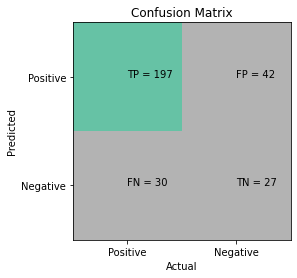

In [36]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

#### TF-IDF word features

Accuracy Score - 0.7635135135135135


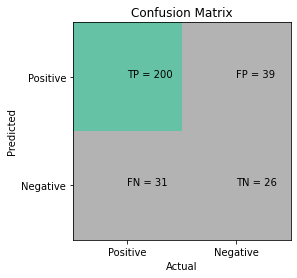

In [37]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

### <a id='6B'>B. Predictions on 'key phrases' based features</a>

#### BOW Phrase features

Accuracy Score - 0.6925675675675675


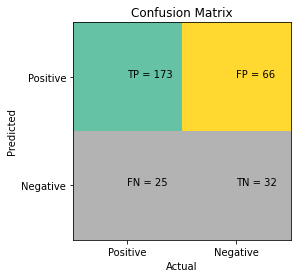

In [38]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

#### TF-IDF word features

Accuracy Score - 0.6925675675675675


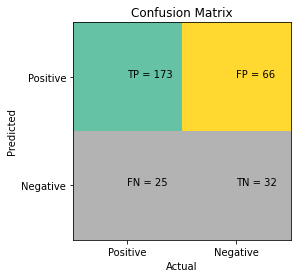

In [39]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

# Conclusion

Features extracted from 'key words' helps model in performing better. They have better positive predictions than the later one. However, using 'key-phrase' based features improves the negative predictions.